# Scripting Sculptor 01 - Modelling the example spectrum in a script

In this notebook we will introduce on how to use Sculptor's SpecFit and SpecModel classes to generate a Sculptor fit within a python script. 

The code in this example that generates the model fit is also available as a pure python script in the examples folder: *example_fit_setup_script.py*

We begin by importing the modules we need for this example. In addition to the SpecFit, SpecModel, and SpecOneD classes we need *pkg_resources* to easily access the SDSS quasar example spectrum, which is provided in sculptor/data/example_spectra.

In [1]:
# Matplotlib statements to make plots nice 
# %matplotlib notebook
from IPython.display import set_matplotlib_formats
import matplotlib.pyplot as plt 
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300
# set_matplotlib_formats('svg')


In [2]:
import pkg_resources

from sculptor import specfit as scfit
from sculptor import speconed as scspec
from sculptor import specmodel as scmod

[INFO] Import "sculptor-extensions" package: my_extension
[INFO] Import "sculptor-extensions" package: qso
[INFO] FeII iron template of Vestergaard & Wilkes 2001 found. If you will be using these templates in your model fit and publication, please add the citation to the original work, ADS bibcode: 2001ApJS..134....1V
[INFO] FeII iron template of Tsuzuki et al. 2006 found. If you will be using these templates in your model fit and publication, please add the citation to the original work, ADS bibcode: 2006ApJ...650...57T
[INFO] FeII iron template of Boroson & Green 1992 found. If you will be using these templates in your model fit and publication, please add the citation to the original work, ADS bibcode: 1992ApJS...80..109B


These imports automatically intialize some global variables, which allow you to use the model masks and functions defined in Sculptor and its extensions. We will take a look at how to write Sculptor extensions in a later tutorial. 
Sculptor comes with two extensions "my_extension", which provides an example on how to set up your own extension, and the "qso" extension, which we will use heavily in this example. The "qso" extension also comes with additional data, e.g. FeII iron templates. If you want to use them in your work Sculptor reminds you where to find the original papers, so you can cite them appropriately. 

## Initializing the SpecFit object

Let us begin by importing the SDSS quasar spectrum. The quasar is at a redshift of z=3.227, which we will use for initializing the SpecFit class.

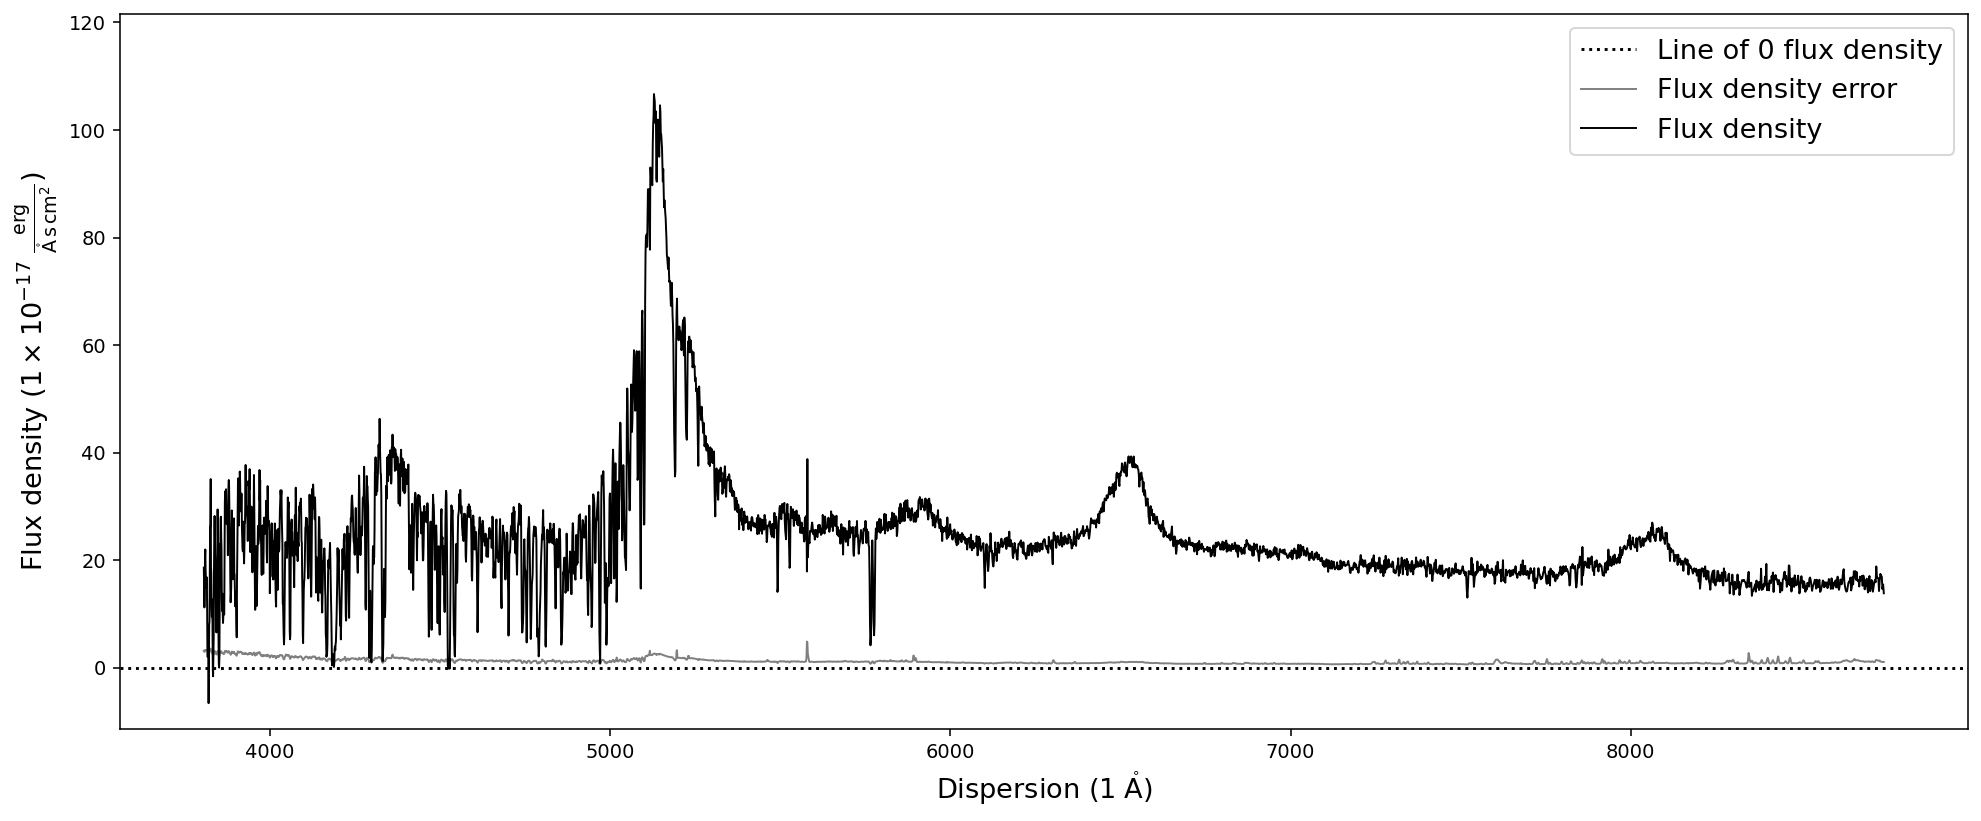

In [3]:
# Initialize a new SpecOneD object and read in the quasar spectrum
spec = scspec.SpecOneD()
filename = pkg_resources.resource_filename('sculptor', 'data/example_spectra/J030341.04-002321.8_0.fits')
spec.read_sdss_fits(filename)

redshift = 3.227

# Plot the quasar spectrum for confirmation that everything worked well.
spec.plot()

In the next step we initialize the SpecFit object with the SpecOneD spectrum and also supply the redshift information.

In [4]:
# Initialize SpecFit object
fit = scfit.SpecFit(spec, redshift)

The SpecFit object currently does not include any models and if we use the *.plot()* method, it will only show us the quasar spectrum. However, we can check the rest-frame dispersion axis, if the redshift keyword was used correctly.

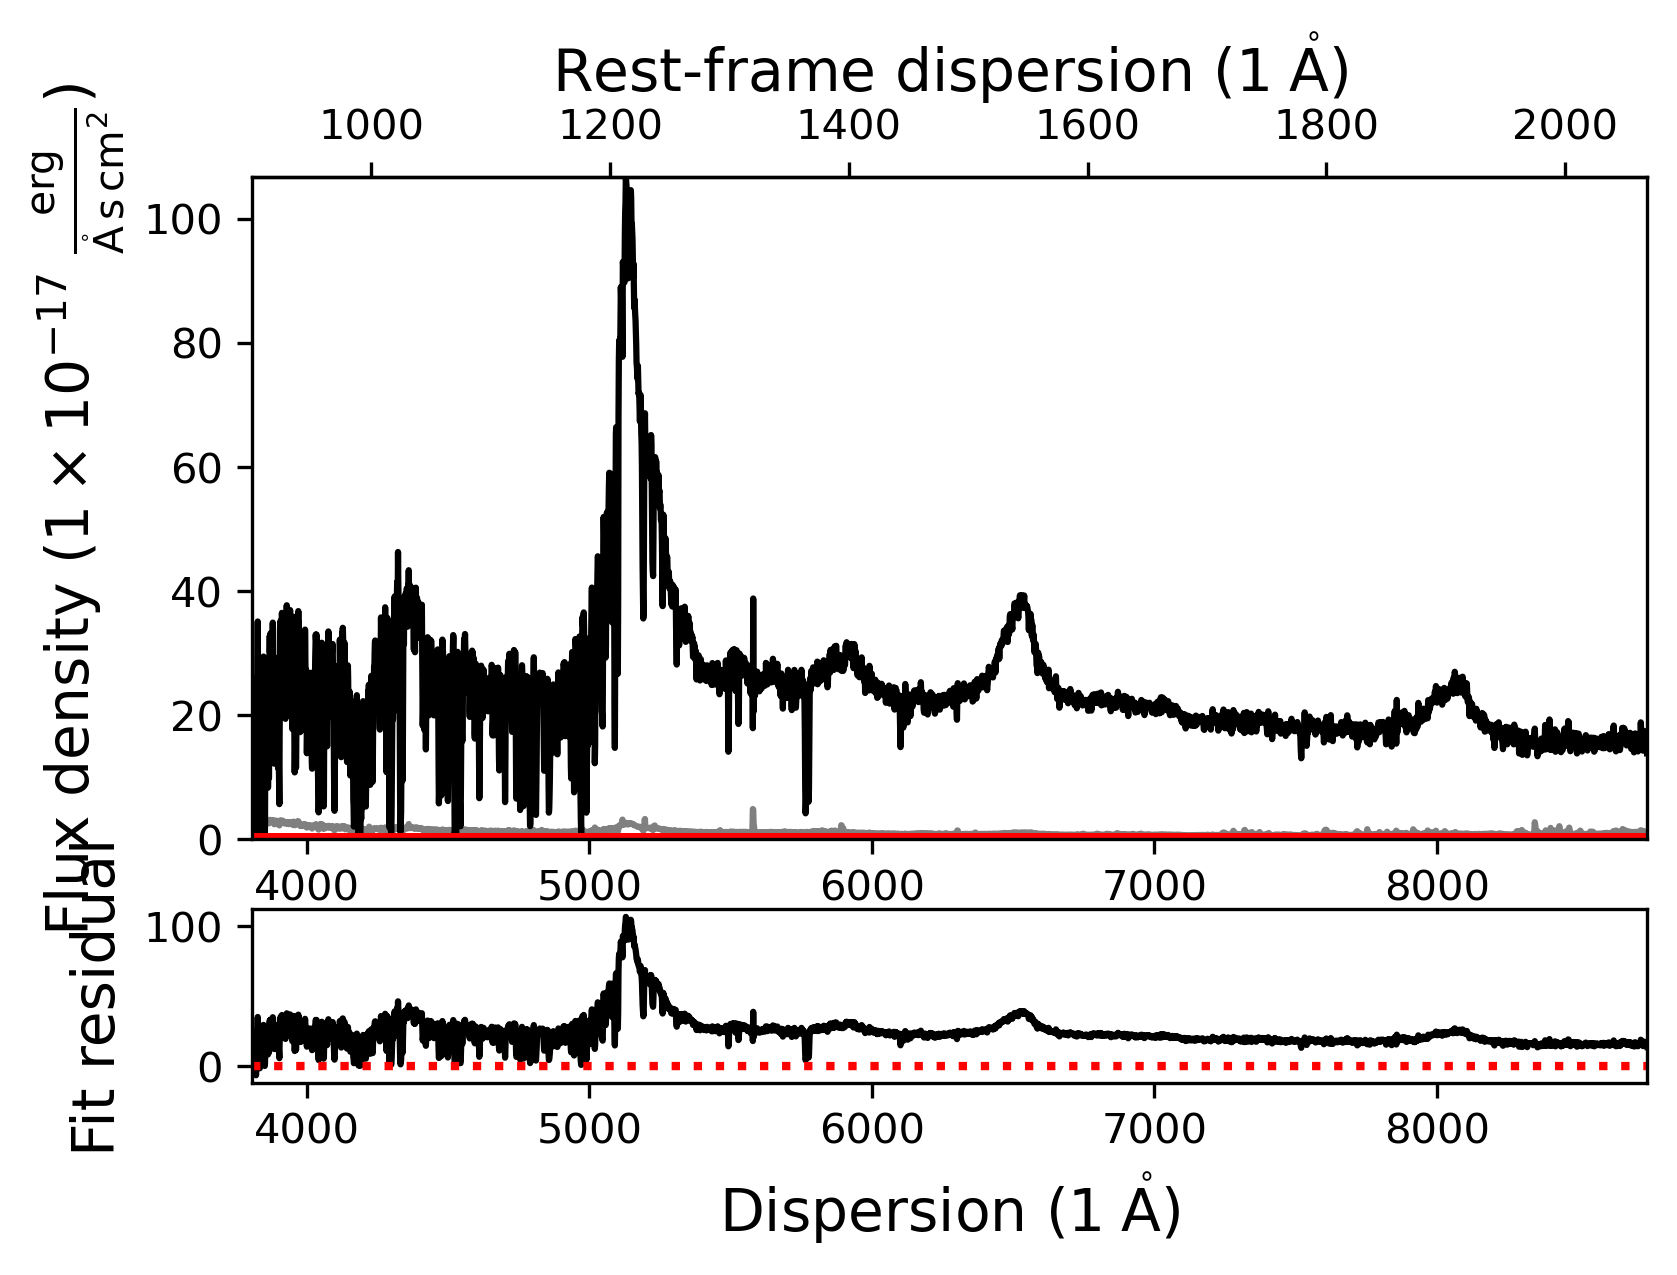

In [5]:
fit.plot()

## Adding our first SpecModel object - Fitting the continuum

In the next step we want to add a simple continuum model to our fit. However, we currently don't really know which models and masks are available to us based on Sculptor and its loaded extensions. Let's get a list of all model names and mask names. This information is available as a global variable in the sculptor.specmodel module:

In [6]:
print('MODEL FUNCTIONS:')
for model_func in scmod.model_func_list:
    print (model_func)
print('\n')
print('MASKS:')
for mask in scmod.mask_presets:
    print(mask)

MODEL FUNCTIONS:
Constant (amp)
Power Law (amp, slope)
Gaussian (amp, cen, sigma, shift)
Lorentzian (amp, cen, gamma, shift)
My Model
Power Law (2500A)
Power Law (2500A) + BC
Power Law (2500A) + BC (fractional)
Line model Gaussian
SiIV (2G components)
CIV (2G components)
MgII (2G components)
HBeta+[OIII] (6G components)
CIII] complex (3G components)
FeII template 1200-2200 (VW01, cont)
FeII template 1200-2200 (VW01, split)
FeII template 2200-3500 (VW01, cont)
FeII template 2200-3500 (VW01, split)
FeII template 2200-3500 (T06, cont)
FeII template 2200-3500 (T06, split)
FeII template 3700-5600 (BG92, cont)
FeII template 3700-5600 (BG92, split)


MASKS:
My mask
QSO Cont.W. VP06
QSO Fe+Cont.W. CIV Shen11
QSO Fe+Cont.W. MgII Shen11
QSO Fe+Cont.W. HBeta Shen11
QSO Fe+Cont.W. HAlpha Shen11


Using these models when writing Sculptor scripts usually requires to fully understand their parameters and functionality. Therefore, it is adviseable to study their source code, before attempting to write scripts.

In order to fit a model to the spectrum, we need to first add a SpecModel object to our fit (SpecFit object). Then we can access this SpecModel and add model functions to it. In order to fit the SpecModel 

In [7]:
# Add the continuum SpecModel
fit.add_specmodel()
# We access the initialized SpecModel object by using the first item in the SpecFit.specmodels list
contmodel = fit.specmodels[0]
# Let us rename this SpecModel 'Continuum'
contmodel.name = 'Continuum'

# Define the model function name
model_name = 'Power Law (2500A)'
# Define the model prefix
# It is important to keep track of the prefix to later access this model in the analysis
model_prefix = 'PL_'
# Add the model function to the SpecModel
contmodel.add_model(model_name, model_prefix)

We have now added the model function to the SpecModel 'Continuum'. However, we cannot yet fit the model successfully as we have not defined the regions to which the continuum model should be fit. Let us add them manually based. The exact fit regions for the continuum model of this quasar have been determined beforehand.

In [8]:
contmodel.add_wavelength_range_to_fit_mask(8300, 8620)
contmodel.add_wavelength_range_to_fit_mask(7105, 7205)
contmodel.add_wavelength_range_to_fit_mask(5400, 5450)
contmodel.add_wavelength_range_to_fit_mask(5685, 5750)
contmodel.add_wavelength_range_to_fit_mask(6145, 6212)

[INFO] Manual mask range 8300 8620
[INFO] Manual mask range 7105 7205
[INFO] Manual mask range 5400 5450
[INFO] Manual mask range 5685 5750
[INFO] Manual mask range 6145 6212


Now that the fit mask has been updated we can fit the continuum model and plot the resulting fit. We can either use the *contmodel.plot()* function to only show the SpecModel components or use the *fit.plot()* function to show all SpecModels fits.

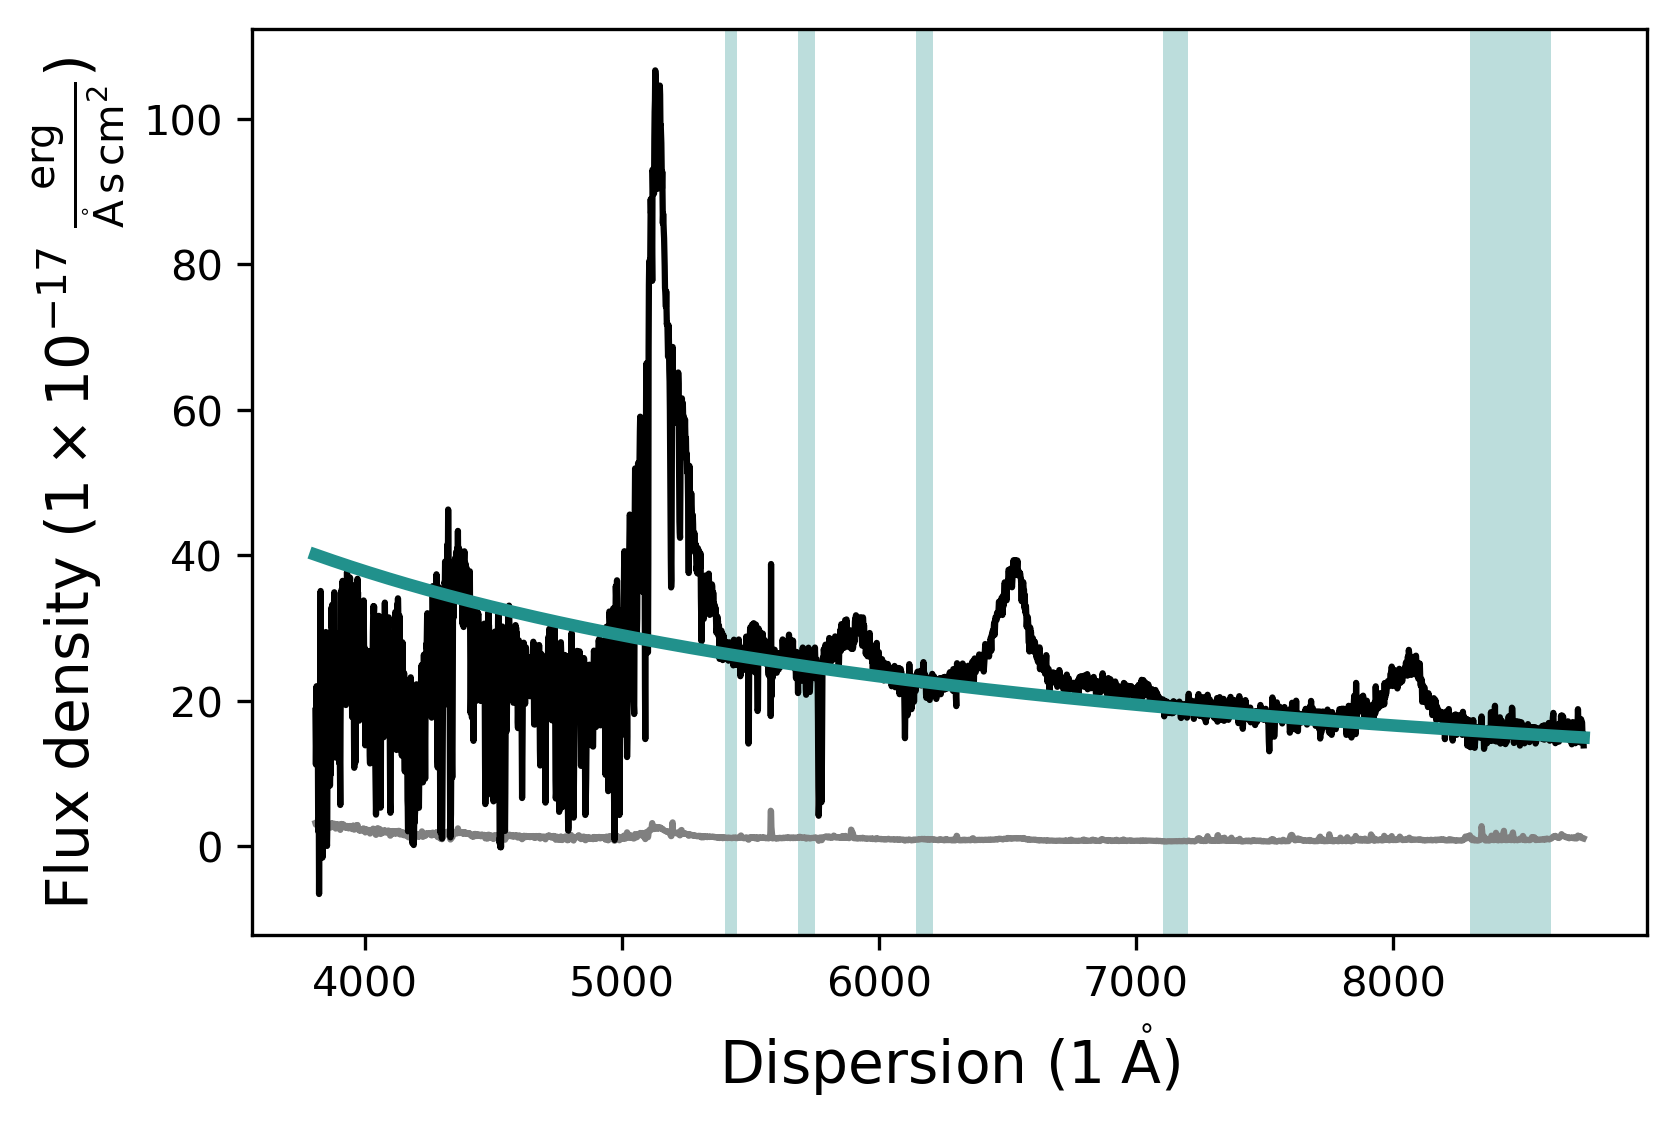

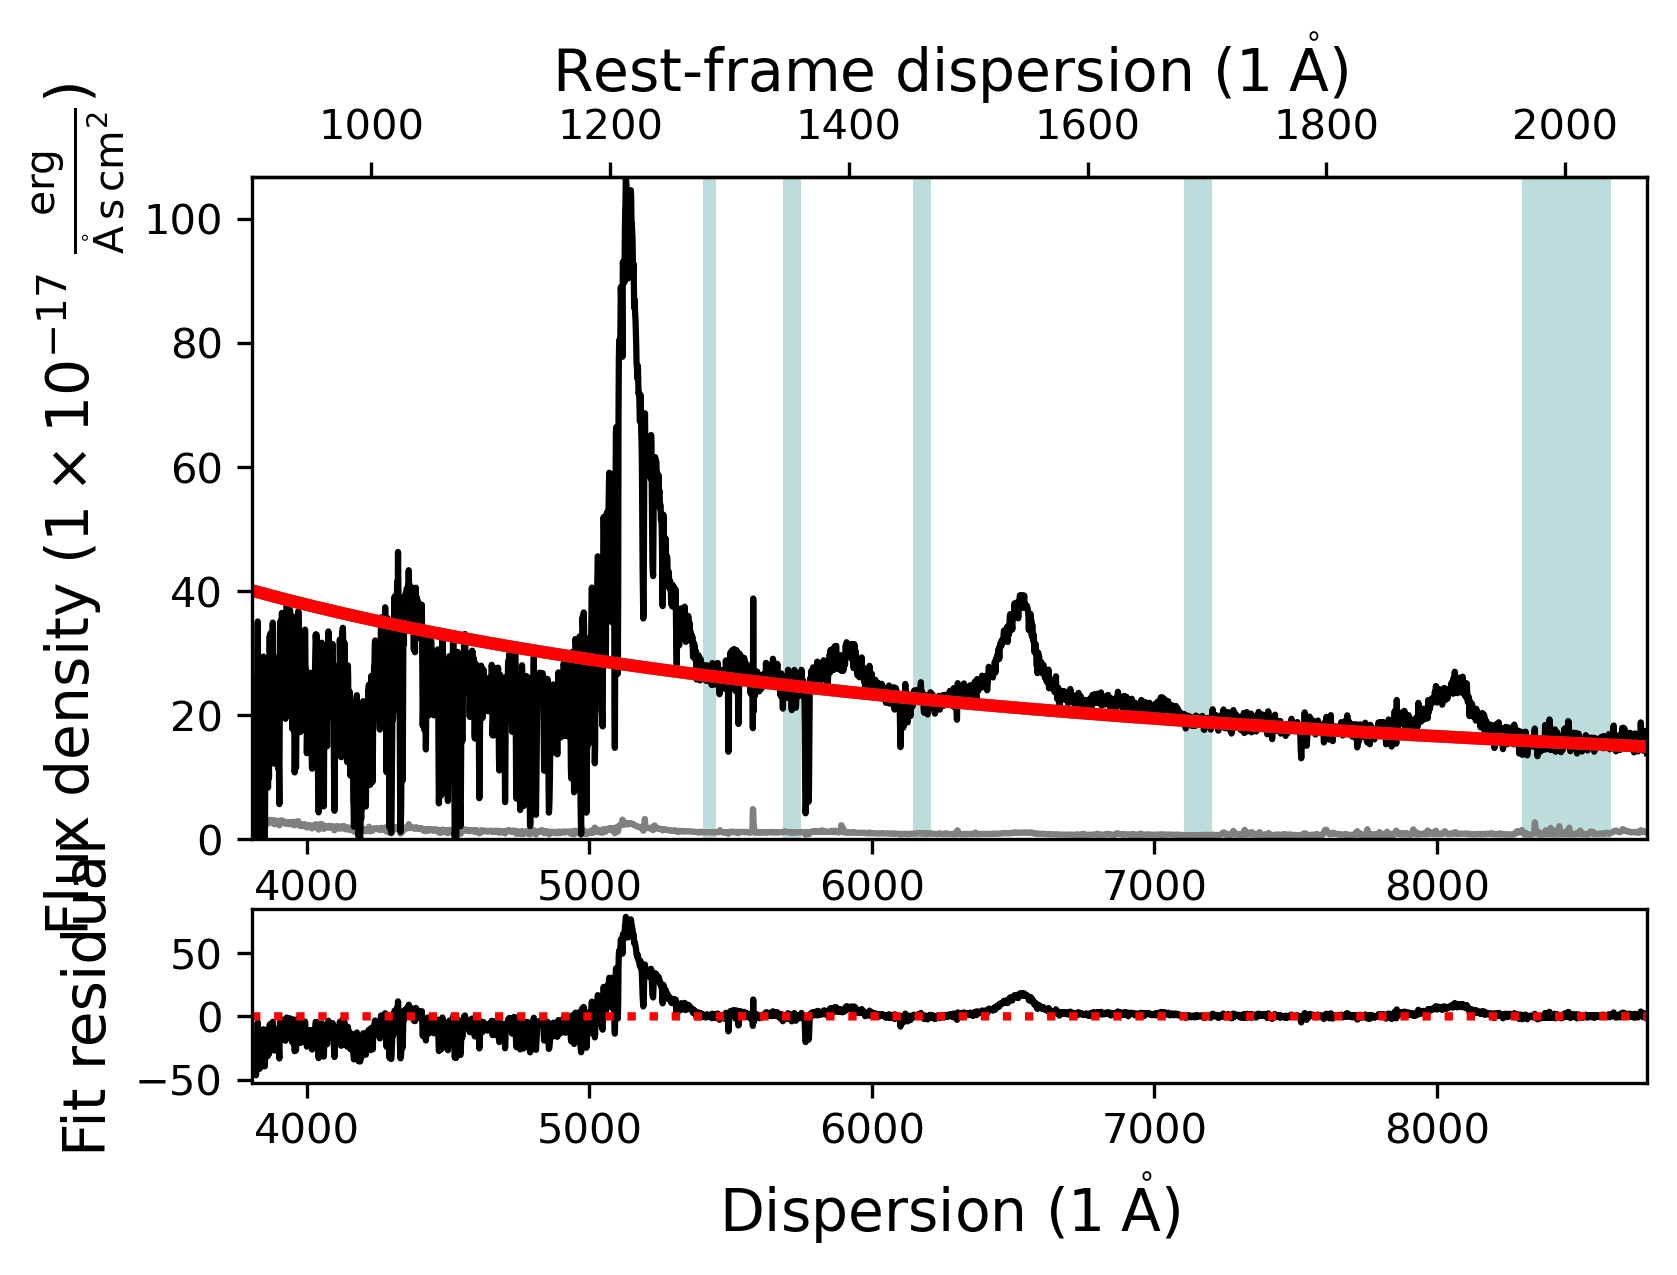

In [9]:
# Fit the continuum model
contmodel.fit()
# Plot the fitted continuum model and the spectrum
contmodel.plot()
# Plot the SpecFit fit with all SpecModels (We only have 1 at the moment)
fit.plot()

## Adding and manipulating a SpecModel - Fitting the SiIV line

In our next step we will add an emission line model to fit the SiIV emission line at a rest-frame wavelength of ~1400A. To do this we start by adding another SpecModel to our fit and specify the wavelength regions (in observed-frame) we want to use for the fit.

In [10]:
# Add the SiIV emission line model
fit.add_specmodel()
# Access the SpecModel object by choosing the second SpecModel object in the SpecFit
# specmodels list.
siiv_model = fit.specmodels[1]
# Rename the SpecModel 
siiv_model.name = 'SiIV_line'

# Add wavelength regions to the SpecModel for the fit
siiv_model.add_wavelength_range_to_fit_mask(5790, 5870)
siiv_model.add_wavelength_range_to_fit_mask(5910, 6015)

[INFO] Manual mask range 5790 5870
[INFO] Manual mask range 5910 6015


However, we will use the pre-defined 'SiIV (2G components)' model function from the Sculptor qso extension, which has pre-defined model prefixes. Therefore, we pass a *None* as the model prefix here. 

The model functions allow to pass additional keyword arguments that modify the redshift or amplitude of the emission line model. The redshift is automatically passed by the SpecModel class if we don't specify a different value here. In this case we only want to pass an amplitude. 

In [11]:
model_name = 'SiIV (2G components)'
model_prefix = None
siiv_model.add_model(model_name, model_prefix, amplitude=20)

The 'SiIV (2G components)' model function added two emission line models with the prefixes 'SiIV_A_' and 'SiIV_B_' to our SpecModel object. We can check whether the models were successfully added to the SpecModel object by accessing the SpecModel 'model_list'. The items in the model list are LMFIT *Model* objects.

In [12]:
for model in siiv_model.model_list:
    print(model)

<lmfit.Model: Model(line_model_gaussian, prefix='SiIV_A_')>
<lmfit.Model: Model(line_model_gaussian, prefix='SiIV_B_')>


We see that two model functions of the type 'line_model_gaussian' have been added to the SiIV SpecModel. 
By default the model function holds the redshift parameter fixed during the fit. However, for our purposes we want the redshift to be a variable. To change this we need to access the parameters of the model function. 

The parameters for each of the models in the 'model_list' are stored in the 'params_list'. Each item in the 'params_list' is a LMFIT *Parameters* object, holding the individual parameters of the associated model from the 'model_list'.

In [13]:
for params in siiv_model.params_list:
    print(params)
    print('\n')

Parameters([('SiIV_A_z', <Parameter 'SiIV_A_z', value=3.227 (fixed), bounds=[3.0656499999999998:3.38835]>), ('SiIV_A_amp', <Parameter 'SiIV_A_amp', value=40, bounds=[0.2:20000]>), ('SiIV_A_cen', <Parameter 'SiIV_A_cen', value=1399.8 (fixed), bounds=[-inf:inf]>), ('SiIV_A_fwhm_km_s', <Parameter 'SiIV_A_fwhm_km_s', value=2500, bounds=[300:20000]>), ('SiIV_A_shift_km_s', <Parameter 'SiIV_A_shift_km_s', value=0 (fixed), bounds=[-200:200]>)])


Parameters([('SiIV_B_z', <Parameter 'SiIV_B_z', value=3.227 (fixed), bounds=[3.0656499999999998:3.38835]>), ('SiIV_B_amp', <Parameter 'SiIV_B_amp', value=40, bounds=[0.2:20000]>), ('SiIV_B_cen', <Parameter 'SiIV_B_cen', value=1399.8 (fixed), bounds=[-inf:inf]>), ('SiIV_B_fwhm_km_s', <Parameter 'SiIV_B_fwhm_km_s', value=2500, bounds=[300:20000]>), ('SiIV_B_shift_km_s', <Parameter 'SiIV_B_shift_km_s', value=0 (fixed), bounds=[-200:200]>)])




To access a single LMFIT *Parameter* object from the *Parameters* we need to use its name, which consists of the model prefix and the parameter name, which are shown above. 

By accessing a specific parameters we can change its attributes, defined in the LMFIT documentation:
* name (str) – Name of the Parameter.
* value (float, optional) – Numerical Parameter value
* vary (bool, optional) – Whether the Parameter is varied during a fit (default is True).
* min (float, optional) – Lower bound for value (default is -numpy.inf, no lower bound).
* max (float, optional) – Upper bound for value (default is numpy.inf, no upper bound).
* expr (str, optional) – Mathematical expression used to constrain the value during the fit (default is None).

We will now change the *vary* attribute of the redshift parameters 'SiIV_A_z' of model function 0, and 'SiIV_B_z' of model function 1 to *True*.

In [14]:
# Make the redshifts variable parameters
params = siiv_model.params_list[0]
params['SiIV_A_z'].vary = True
params = siiv_model.params_list[1]
params['SiIV_B_z'].vary = True

Then we fit the SiIV SpecModel.

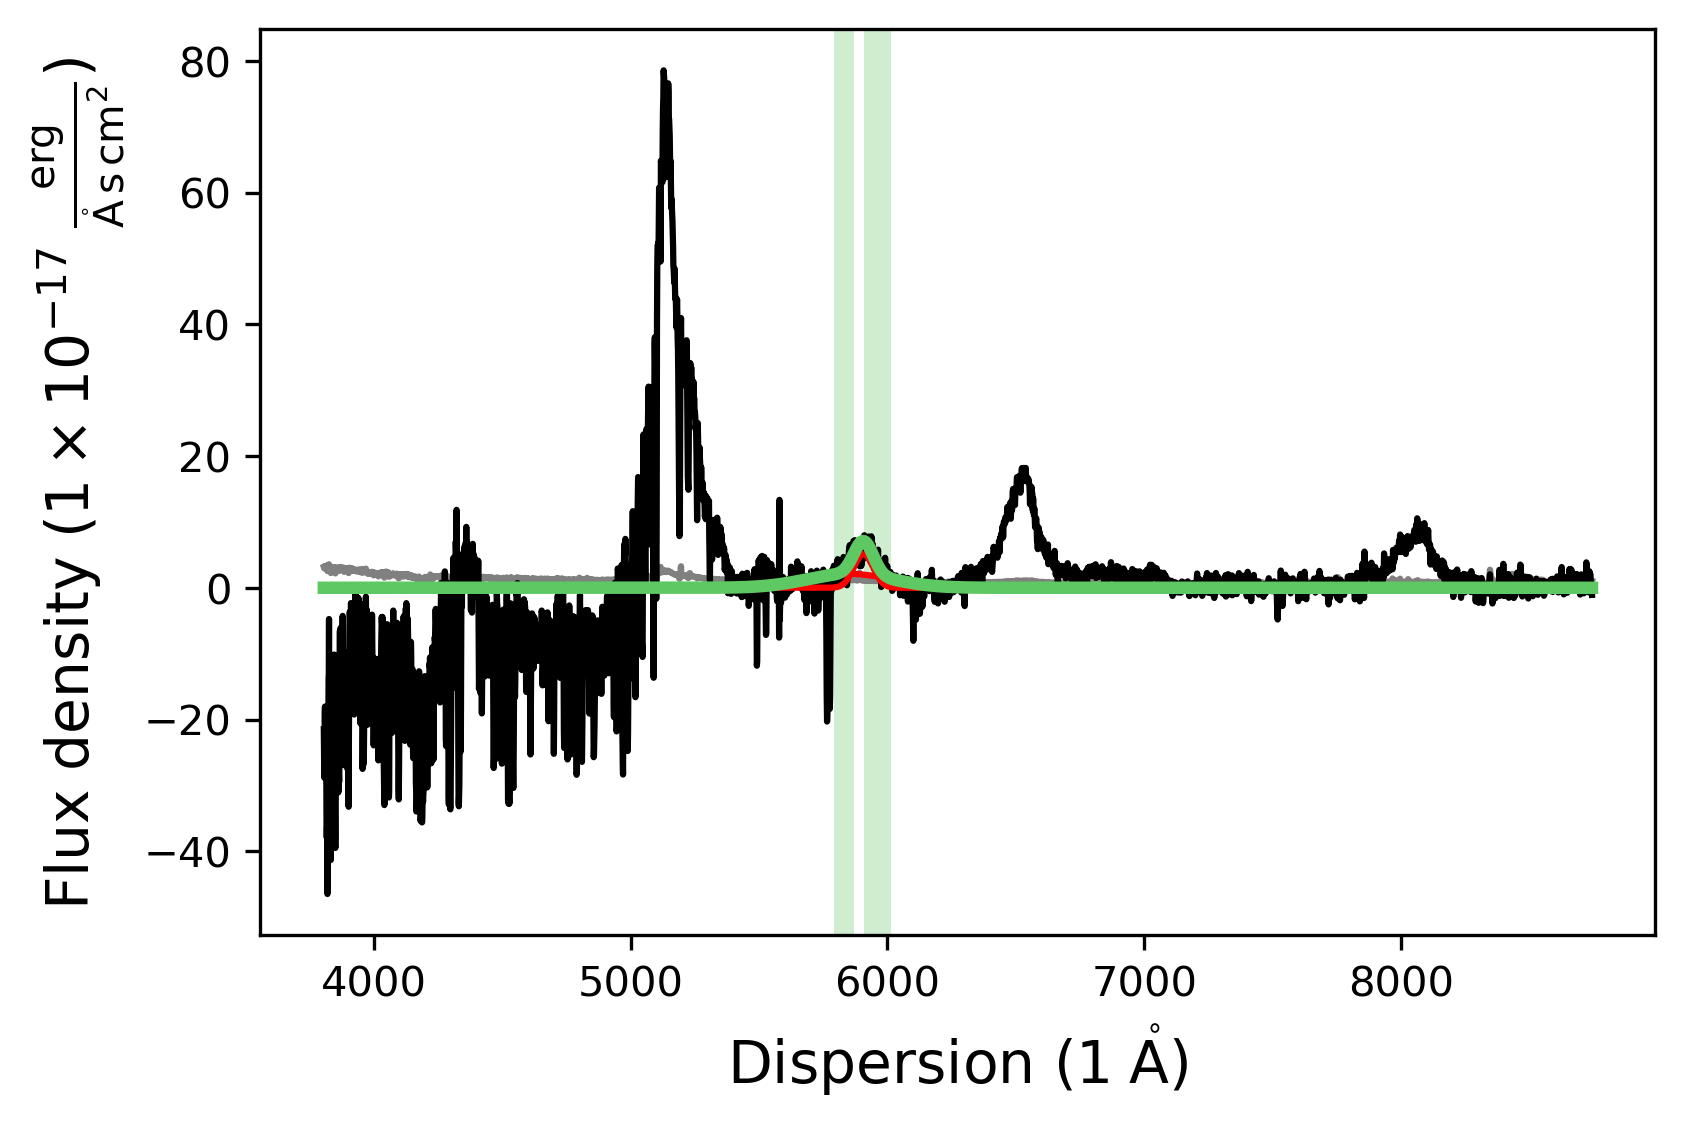

In [15]:
# Fit the SiIV SpecModel
siiv_model.fit()
# Display the fitted SpecModel
siiv_model.plot()

## Fitting the CIV line

In the next step we add the CIV model, basically repeating the same procedure.

[INFO] Manual mask range 6240 6700


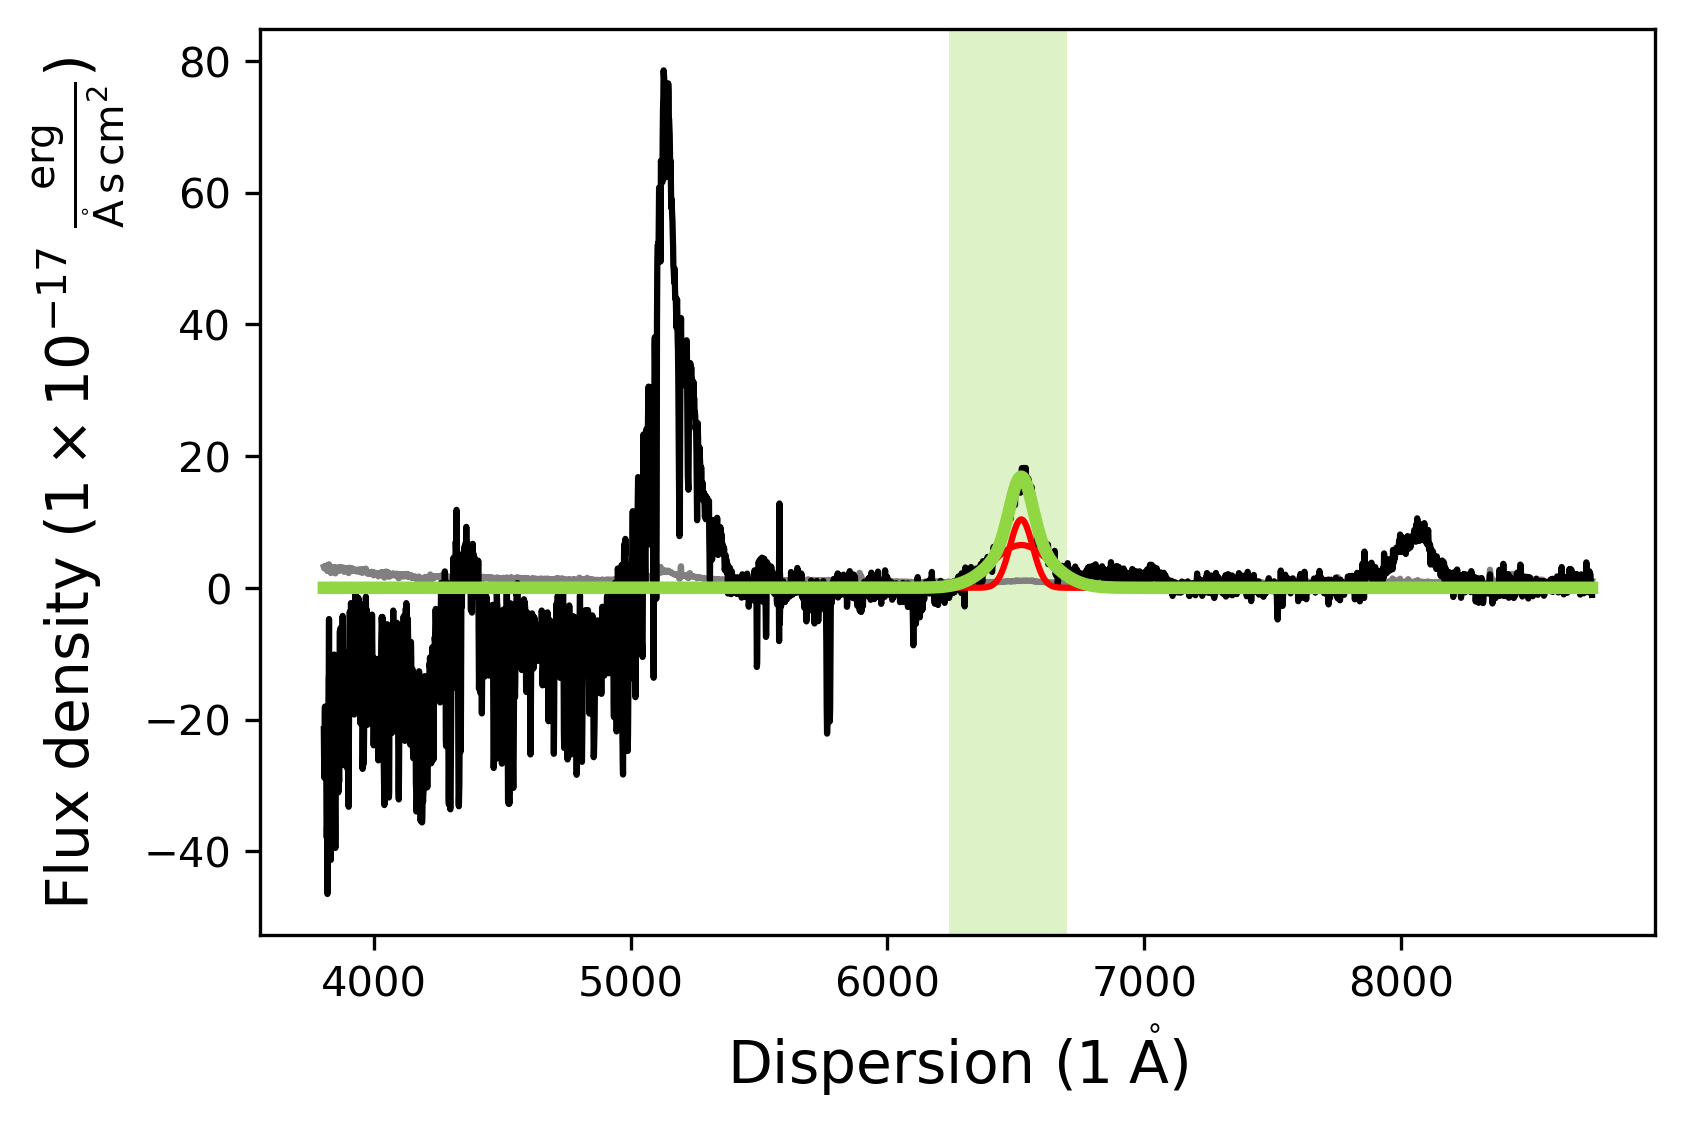

In [16]:
# Add the CIV emission line model
fit.add_specmodel()
civ_model = fit.specmodels[2]
civ_model.name = 'CIV_line'

civ_model.add_wavelength_range_to_fit_mask(6240, 6700)

model_name = 'CIV (2G components)'
model_prefix = None
civ_model.add_model(model_name, model_prefix, amplitude=10)

# Make the redshift a variable parameter
params = civ_model.params_list[0]
params['CIV_A_z'].vary = True
params = civ_model.params_list[1]
params['CIV_B_z'].vary = True

civ_model.fit()

civ_model.plot()

## Fitting the CIII] line

After we successfully added the CIV line to the fit, we will now add a model for the SiIII], AlIII, and CIII] lines. While the previous SiIV and CIV model functions were comprised of two individual model functions called 'line_model_gaussian', the CIII] complex model is one model function comprised of three Gaussians with set central wavelength values.

[INFO] Manual mask range 7800 8400


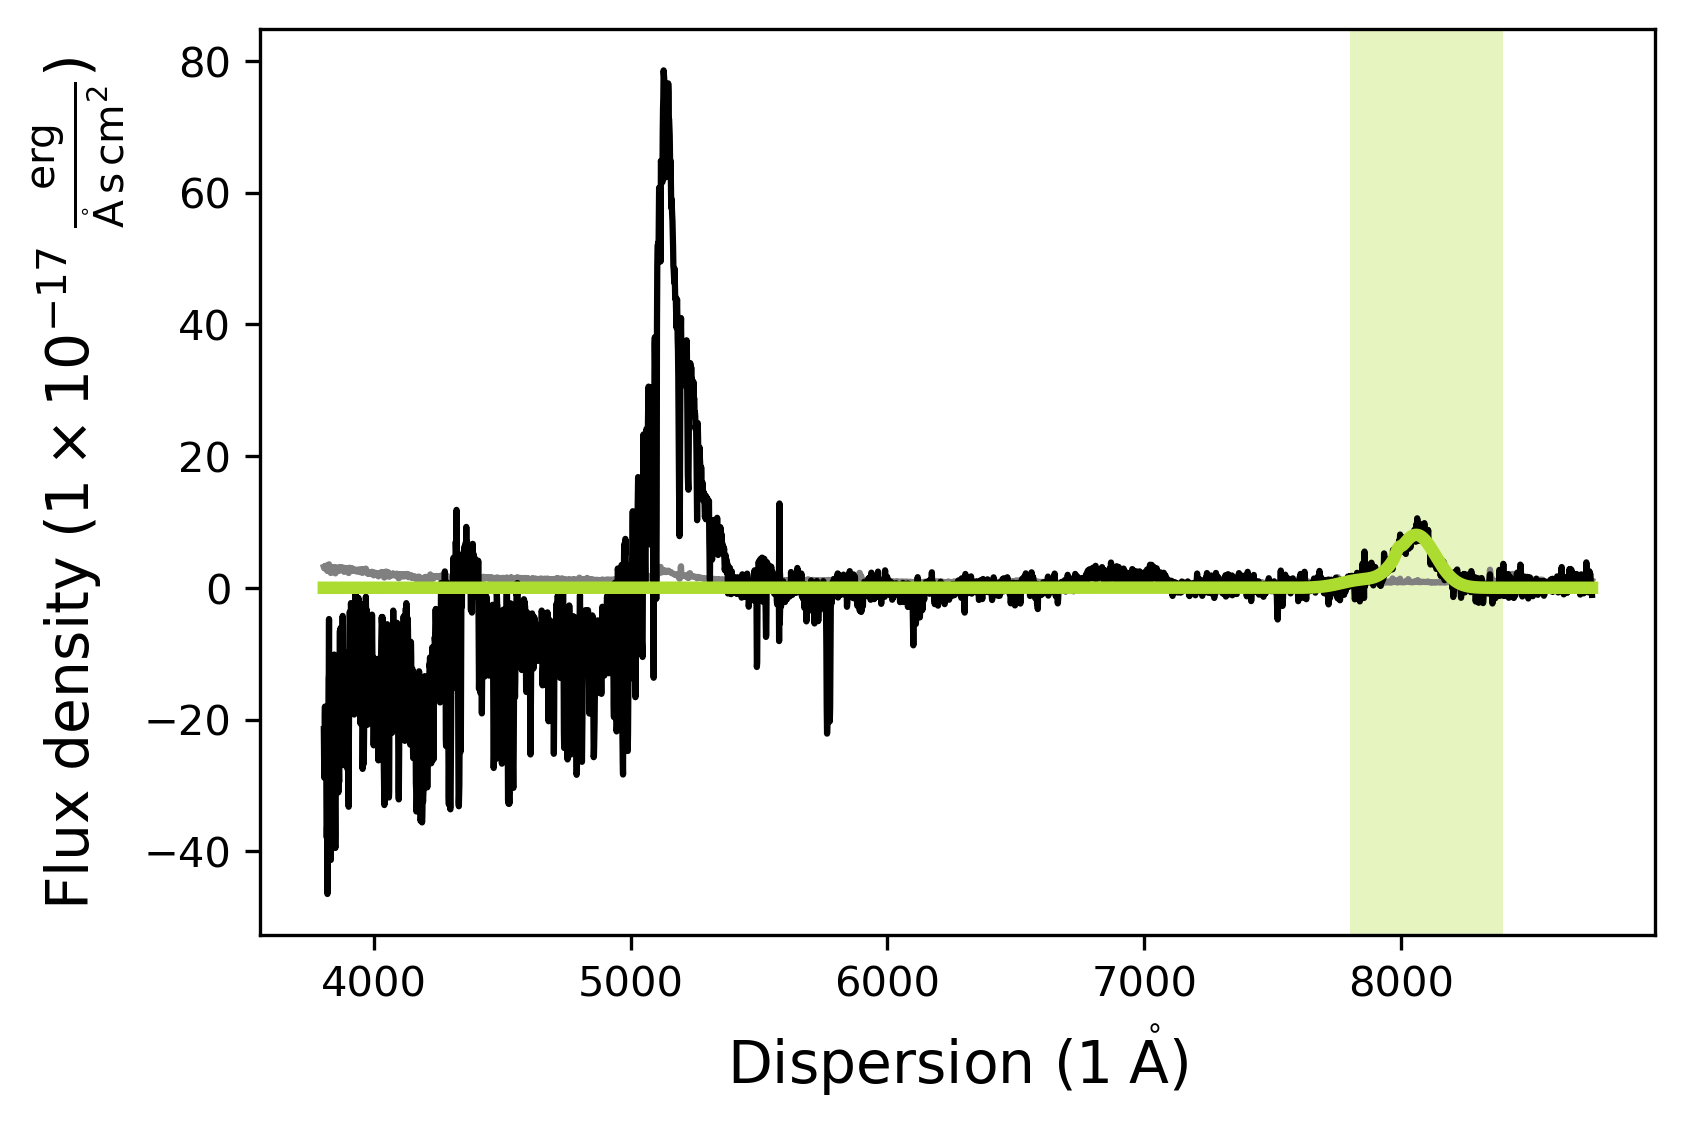

In [17]:
# Add the CIII] complex emission line model
fit.add_specmodel()
ciii_model = fit.specmodels[3]
ciii_model.name = 'CIII]_complex'

ciii_model.add_wavelength_range_to_fit_mask(7800, 8400)

model_name = 'CIII] complex (3G components)'
model_prefix = None
ciii_model.add_model(model_name, model_prefix, amplitude=2)

params = ciii_model.params_list[0]
params['CIII_z'].vary = True

# Initial fit
ciii_model.fit()
# Second fit to make sure the model converged
ciii_model.fit()

# Plot the model
ciii_model.plot()

## Adding a basic line model (Gaussian) - Fitting absorption lines

Just blueward of the SiIV line this quasar has two prominent absorption features, which we also want to model. For this purpose we use the basic 'Line model Gaussian' model function and provide the parameters values as keyword arguments ourselves.

[INFO] Manual mask range 5760 5790


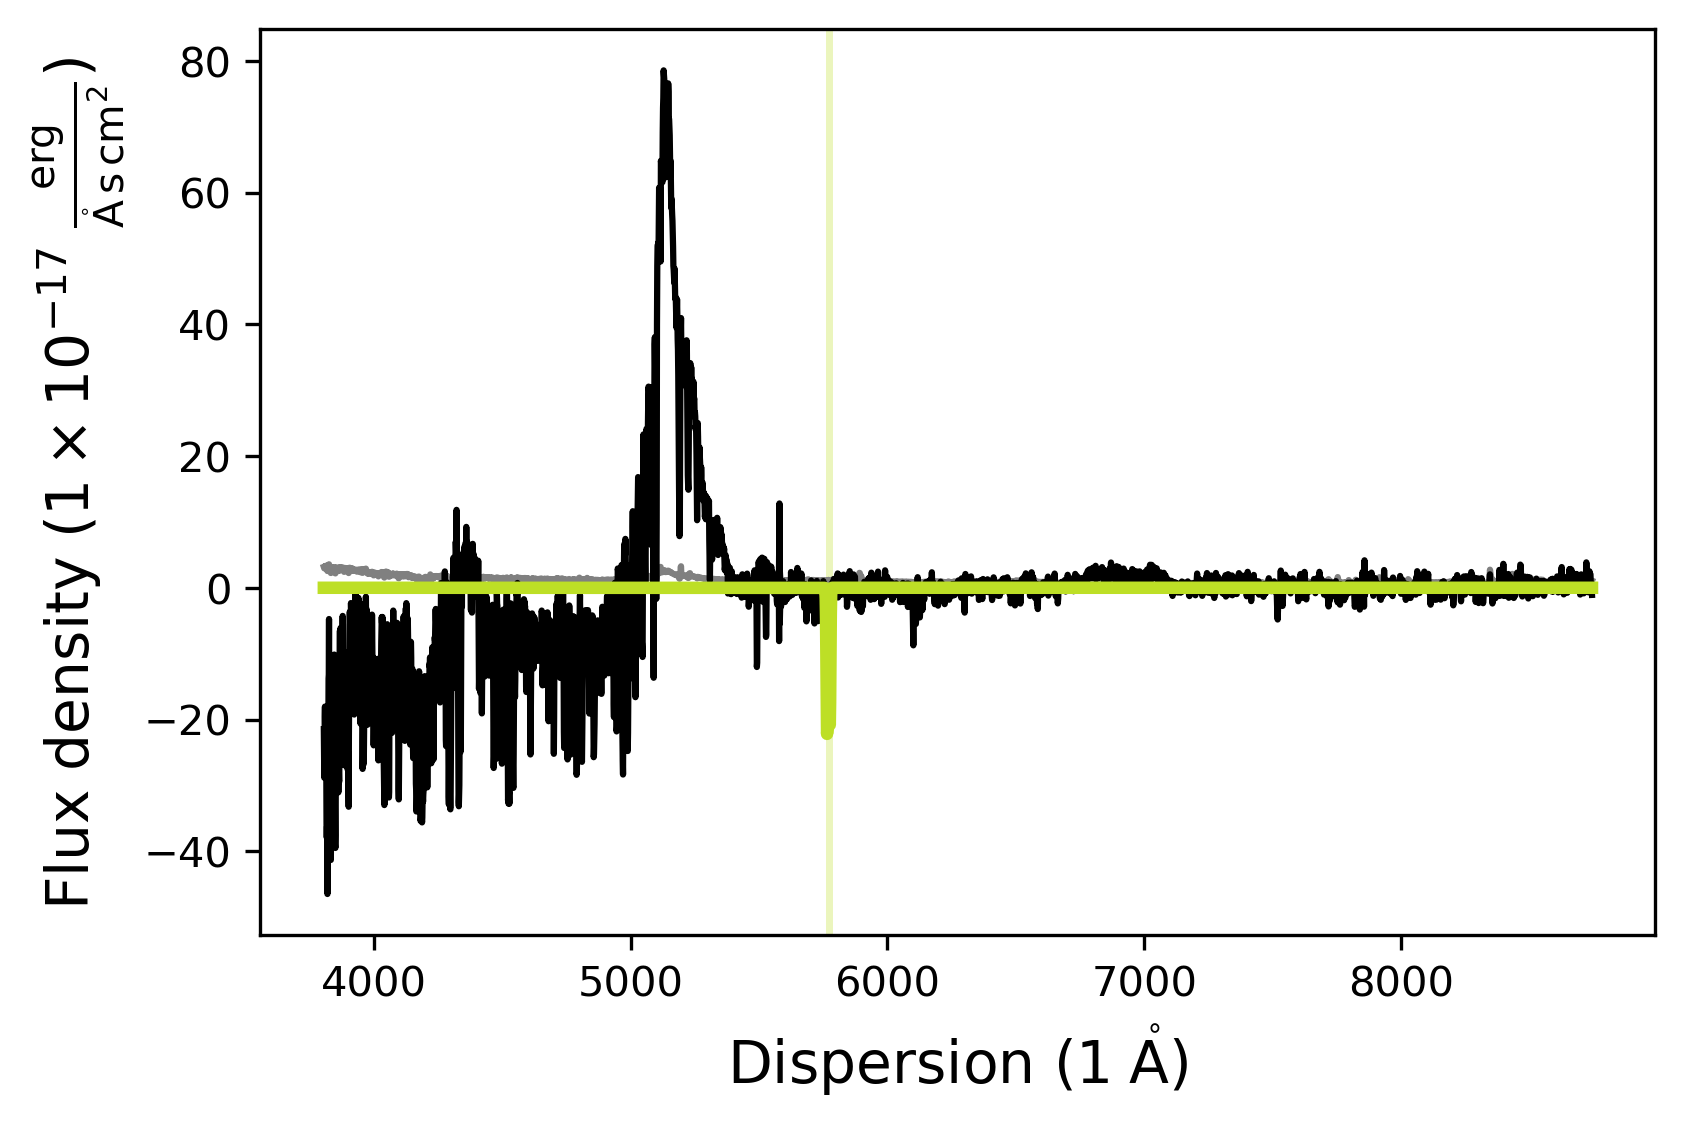

In [18]:
# Add absorption line models
fit.add_specmodel()
abs_model = fit.specmodels[4]
abs_model.name = 'Abs_lines'

abs_model.add_wavelength_range_to_fit_mask(5760, 5790)

model_name = 'Line model Gaussian'
model_prefix = 'Abs_A'
abs_model.add_model(model_name, model_prefix, amplitude=-15,
                    cenwave=5766, fwhm=200, redshift=0)
model_name = 'Line model Gaussian'
model_prefix = 'Abs_B'
abs_model.add_model(model_name, model_prefix, amplitude=-15,
                    cenwave=5776, fwhm=200, redshift=0)

abs_model.fit()

abs_model.plot()

The default *.plot()* function dispersion and flux ranges may not always be appropriate to check whether the model was actually fit appropriately. Using the *matplotlib notebook* functionality one can zoom into the region of the two absorption lines to check whether the SpecModel fit did a good job.

## Visualizing the full quasar model fit

Let us now visualize the entire fit by calling the SpecFit plot function:

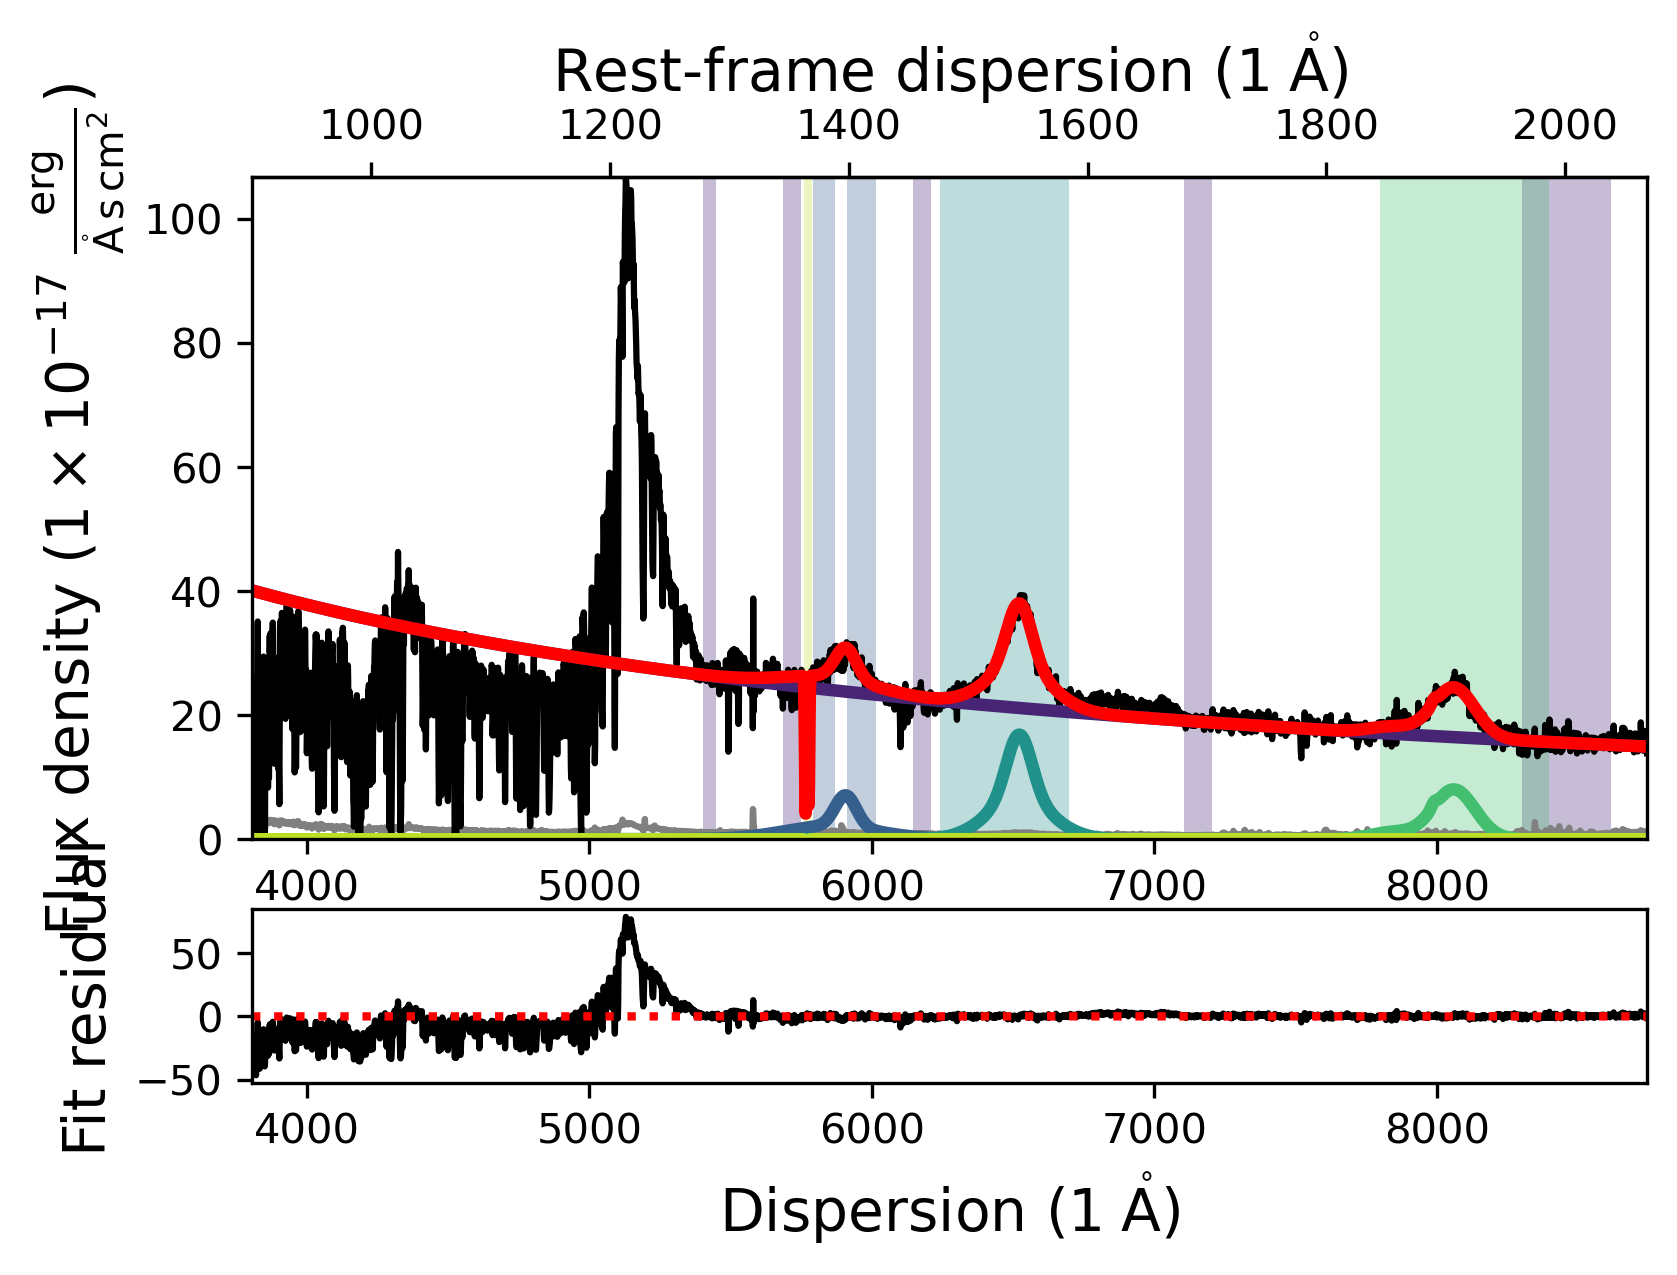

In [19]:
fit.plot()

## Accessing SpecModel fit results and saving them

The fitted quasar model looks reasonable. However, in order to analyze the model we need to understand how to access the fitted parameters. Once a SpecModel has been fit, we can access the fit results simply by calling the *.fit_result* attribute of the SpecModel. It returns the LMFIT fit report for the SpecModel, giving us insight into the model that was fit, the fit statistics, the variables, and the correlations.

In [20]:
# Printing the fit result for the CIV model
civ_model.fit_result

We can save the fit result of each individual SpecModel using the *save_fit_report* function. One has to supply the folder path where the fit report should be saved. As an example we can save the fit report for the CIV SpecModel to the current folder.

In [21]:
# Save the CIV SpecModel fit report to the current folder
civ_model.save_fit_report('.')

# Check if the fit report was saved
! ls

TestSpectralBroadening.ipynb      scripting_sculptor_3.ipynb
example_spectrum_fit              specmodel_CIV_line_fit_report.txt
scripting_sculptor_1.ipynb        speconed_demonstration.ipynb
scripting_sculptor_2.ipynb        spectrum_preparation.ipynb


Let's have a brief look at what was saved exactly:

In [23]:
h = open("specmodel_CIV_line_fit_report.txt", "r")
for line in h:
    print (line)
h.close()

[[Fit Statistics]]

    # fitting method   = leastsq

    # function evals   = 91

    # data points      = 309

    # variables        = 6

    chi-square         = 431.939741

    reduced chi-square = 1.42554370

    Akaike info crit   = 115.497947

    Bayesian info crit = 137.897995

[[Variables]]

    CIV_A_z:           3.20972471 +/- 0.00149698 (0.05%) (init = 3.227)

    CIV_A_amp:         6.48864266 +/- 0.65289123 (10.06%) (init = 10)

    CIV_A_cen:         1549.06 (fixed)

    CIV_A_fwhm_km_s:   12120.9626 +/- 611.211887 (5.04%) (init = 2500)

    CIV_A_shift_km_s:  0 (fixed)

    CIV_B_z:           3.20984577 +/- 7.2028e-04 (0.02%) (init = 3.227)

    CIV_B_amp:         10.3771398 +/- 0.62366575 (6.01%) (init = 10)

    CIV_B_cen:         1549.06 (fixed)

    CIV_B_fwhm_km_s:   4790.44580 +/- 222.062136 (4.64%) (init = 2500)

    CIV_B_shift_km_s:  0 (fixed)

[[Correlations]] (unreported correlations are < 0.100)

    C(CIV_A_amp, CIV_A_fwhm_km_s)       = -0.950

    C(CIV_A

Wonderful! The full fit report, which we displayed above, was saved in the .txt file 'specmodel_CIV line_fit_report.txt'. Let's remove the file before we proceed. 

In [24]:
! rm specmodel_CIV\ line_fit_report.txt
! ls

rm: specmodel_CIV line_fit_report.txt: No such file or directory
TestSpectralBroadening.ipynb      scripting_sculptor_3.ipynb
example_spectrum_fit              specmodel_CIV_line_fit_report.txt
scripting_sculptor_1.ipynb        speconed_demonstration.ipynb
scripting_sculptor_2.ipynb        spectrum_preparation.ipynb


## Full fits, fitting algorithms, and saving your results

### Performing a global consecutive fit and saving the SpecModel fit results
In some cases it might be useful to fit individual SpecModels and save their results. However, in most cases we want to fit all SpecModels consecutively and save all results. For this purpose the SpecFit object has a function called *fit*. It can take a keyword argument *save_results*, which defaults to *False*. If we set it to *True* the fit results will automatically be saved to the current folder. By providing a different *foldername* keyword argument the user can choose the folder, where the fit results will be saved.

In [25]:
# Fit all SpecModels consecutively and save their results to the current folder
fit.fit(save_results=True)

# Check the current folder for the .txt files
! ls

TestSpectralBroadening.ipynb      specmodel_2_FitAll_fit_report.txt
example_spectrum_fit              specmodel_3_FitAll_fit_report.txt
scripting_sculptor_1.ipynb        specmodel_4_FitAll_fit_report.txt
scripting_sculptor_2.ipynb        specmodel_CIV_line_fit_report.txt
scripting_sculptor_3.ipynb        speconed_demonstration.ipynb
specmodel_0_FitAll_fit_report.txt spectrum_preparation.ipynb
specmodel_1_FitAll_fit_report.txt


Note that in this case, the SpecModels have not been saved with their given names, but rather with their list inidices in the specfit.specmodels list. However, if you used easy to understand model prefixes a simple look into the .txt files will let you recover the fit parameters easily. 

To keep the notebook directory clean, let's remove the files again:

In [26]:
# Remove the SpecModel fit report files
! rm *.txt
# Check the directory again
! ls

TestSpectralBroadening.ipynb scripting_sculptor_3.ipynb
example_spectrum_fit         speconed_demonstration.ipynb
scripting_sculptor_1.ipynb   spectrum_preparation.ipynb
scripting_sculptor_2.ipynb


### Choosing the fit algorithm available in LMFIT 

The SpecFit object has a string attribute called *fitting_method*, which allows you to specify with which algorithm LMFIT will fit your model to the data. An overview over which algorithms are implemented in LMFIT can be found [here](https://lmfit.github.io/lmfit-py/fitting.html). The list of names available using Sculptor is saved as a global variable dictionary *fitting_methods* in the SpecModel module, that translates the human readable names of the algorithms into the LMFIT method options. Note that not all of them are fully tested in the Sculptor framework and may lead to errors, if used inappropriately.

In [27]:
for key in scmod.fitting_methods:
    print('Name: {} \n Method {}'.format(key, scmod.fitting_methods[key]))

Name: Levenberg-Marquardt 
 Method leastsq
Name: Nelder-Mead 
 Method nelder
Name: Maximum likelihood via Monte-Carlo Markov Chain 
 Method emcee
Name: Least-Squares minimization 
 Method least_squares
Name: Differential evolution 
 Method differential_evolution
Name: Brute force method 
 Method brute
Name: Basinhopping 
 Method basinhopping
Name: Adaptive Memory Programming for Global Optimization 
 Method ampgo
Name: L-BFGS-B 
 Method lbfgsb
Name: Powell 
 Method powell
Name: Conjugate-Gradient 
 Method cg
Name: Cobyla 
 Method cobyla
Name: BFGS 
 Method bfgs
Name: Truncated Newton 
 Method tnc
Name: Newton GLTR trust-region 
 Method trust-krylov
Name: Trust-region for constrained obtimization 
 Method trust-constr
Name: Sequential Linear Squares Programming 
 Method slsqp
Name: Simplicial Homology Global Optimization 
 Method shgo
Name: Dual Annealing Optimization 
 Method dual_annealing


For more information on the different fitting algorithms, please refer to the LMFIT documentation.

The default method of Sculptor's SpecFit class is always 'Levenberg-Marquardt'. However, this can be easily changed:

Default fitting method:  Levenberg-Marquardt
New fitting method:  Nelder-Mead


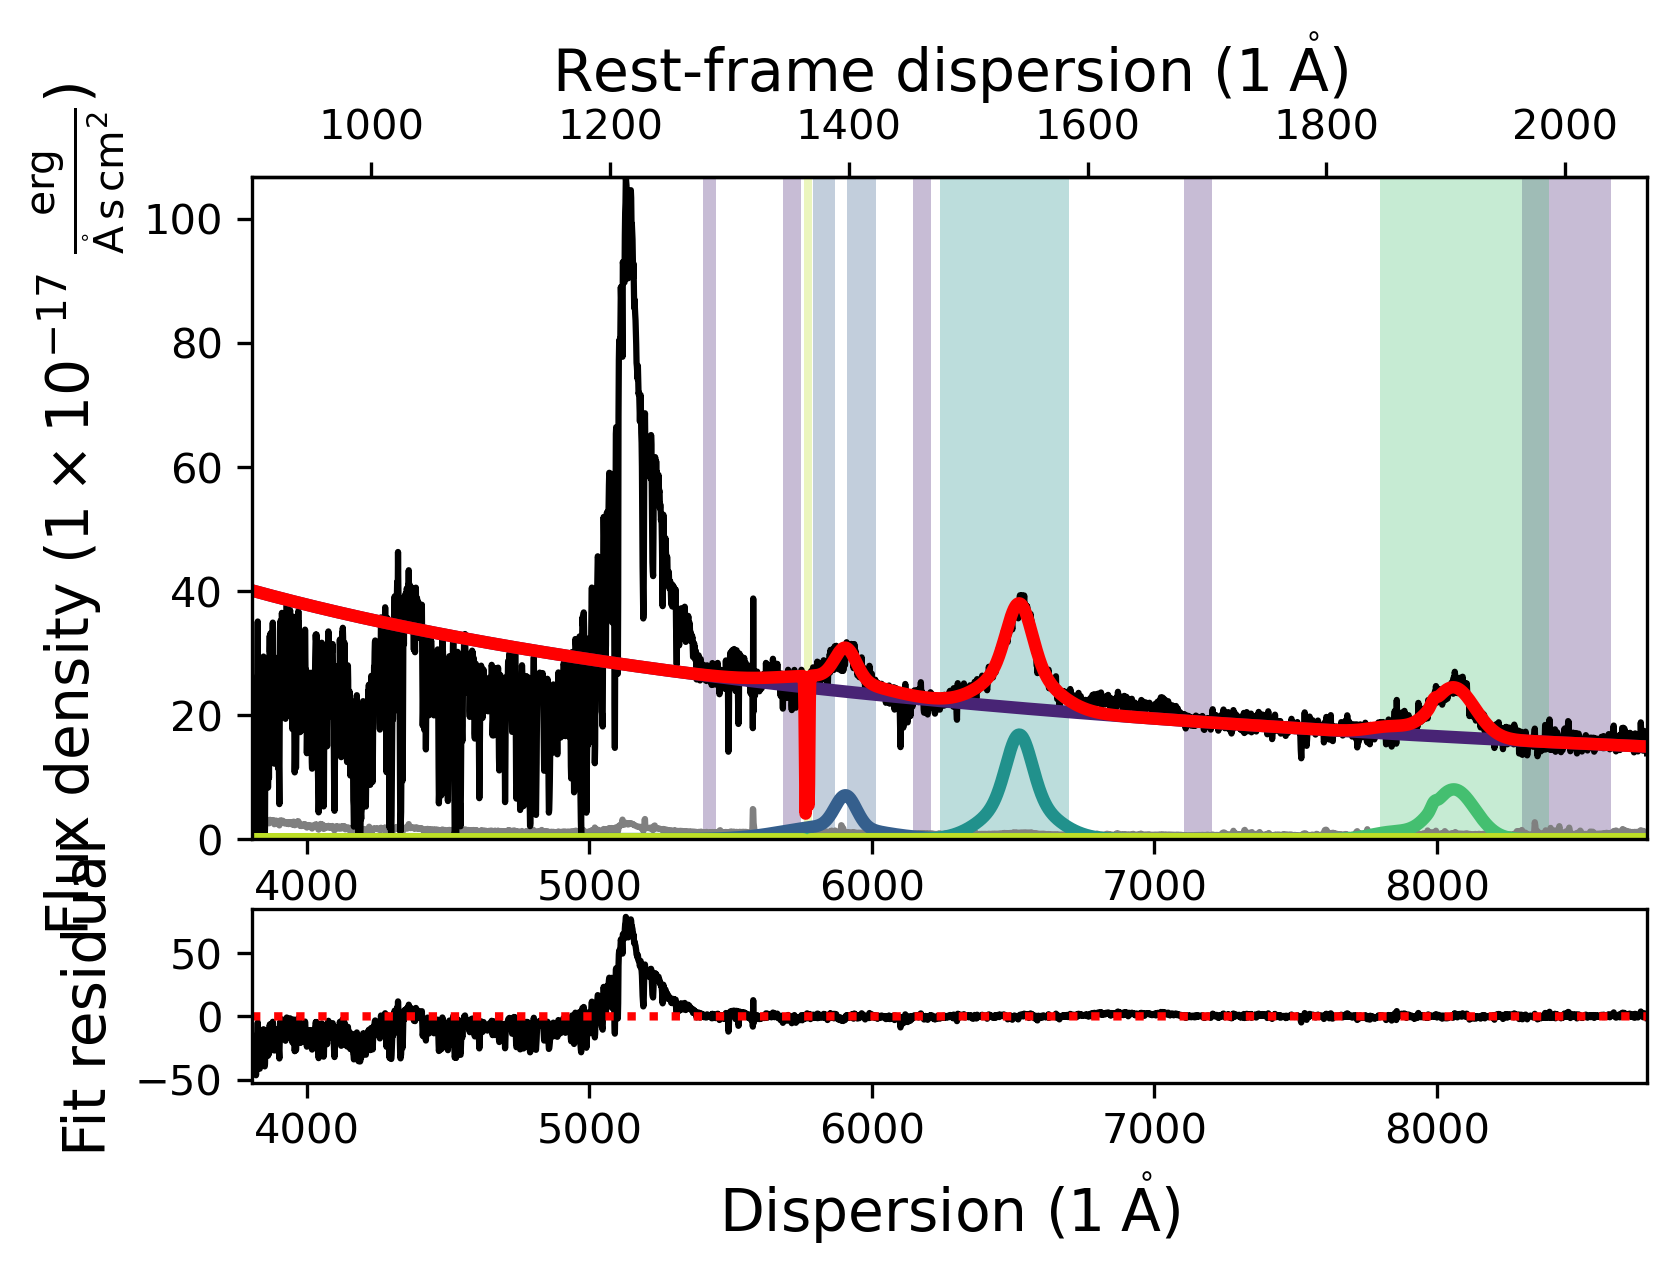

In [28]:
# Current fitting method
print('Default fitting method: ', fit.fitting_method)

# Change fitting method to Nelder-Mead
fit.fitting_method = 'Nelder-Mead'

# Check fitting method again
print('New fitting method: ', fit.fitting_method)

# Fit all SpecModels
fit.fit()
# Display result
fit.plot()



Some of the fitting methods need extra parameters. A prominent example for this is the 'Maximum likelihood via Monte-Carlo Markov Chain', which uses emcee to perform a maximum likelihood fit using MCMC. For this particular method default parameters are implemented. However, we will devote an entire notebook to show how you can use this fitting option to produce science grade results.

### Saving the model fit 

One of the goals of the Sculptor package is to enable easy reproducibility of model fits to astronomical spectra and their analysis. Therefore, you can save your entire fit (SpecFit object) to a folder with the SpecFit *save* function. It takes the folderpath+foldername as an attribute and will create the folder if it does not find it in the specified directory.

In [29]:
# Quick look into the current directory 
! ls 

# Save the SpecFit object
fit.save('example_fit_notebook')

# Check if the folder was created and contents were saved
! ls

TestSpectralBroadening.ipynb scripting_sculptor_3.ipynb
example_spectrum_fit         speconed_demonstration.ipynb
scripting_sculptor_1.ipynb   spectrum_preparation.ipynb
scripting_sculptor_2.ipynb


/opt/anaconda3/envs/sculptor-env/lib/python3.9/site-packages/pandas/core/generic.py:2606: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed-integer,key->block0_values] [items->Index(['value'], dtype='object')]

  pytables.to_hdf(
/opt/anaconda3/envs/sculptor-env/lib/python3.9/site-packages/sculptor/specfit.py:367: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  df = pd.DataFrame(np.array(data), index=columns)
/opt/anaconda3/envs/sculptor-env/lib/python3.9/site-packages/pandas/core/generic.py:2606: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed-integer,key->block0_values] [item

[INFO] Saving SpecModel fit result
[INFO] Saving new model file: example_fit_notebook/0_PL__model.json
[INFO] Saving SpecModel fit result
[INFO] Saving new model file: example_fit_notebook/1_SiIV_A__model.json
[INFO] Saving new model file: example_fit_notebook/1_SiIV_B__model.json
[INFO] Saving SpecModel fit result
[INFO] Saving new model file: example_fit_notebook/2_CIV_A__model.json
[INFO] Saving new model file: example_fit_notebook/2_CIV_B__model.json
[INFO] Saving SpecModel fit result
[INFO] Saving new model file: example_fit_notebook/3_CIII__model.json
[INFO] Saving SpecModel fit result
[INFO] Saving new model file: example_fit_notebook/4_Abs_A_model.json
[INFO] Saving new model file: example_fit_notebook/4_Abs_B_model.json
TestSpectralBroadening.ipynb scripting_sculptor_2.ipynb
example_fit_notebook         scripting_sculptor_3.ipynb
example_spectrum_fit         speconed_demonstration.ipynb
scripting_sculptor_1.ipynb   spectrum_preparation.ipynb


In [30]:
# Check the contents of the saved SpecFit folder
! ls ./example_fit_notebook/

0_PL__model.json          2_fitresult.json          specmodel_0_specdata.hdf5
0_fitresult.json          3_CIII__model.json        specmodel_1_specdata.hdf5
1_SiIV_A__model.json      3_fitresult.json          specmodel_2_specdata.hdf5
1_SiIV_B__model.json      4_Abs_A_model.json        specmodel_3_specdata.hdf5
1_fitresult.json          4_Abs_B_model.json        specmodel_4_specdata.hdf5
2_CIV_A__model.json       4_fitresult.json          spectrum.hdf5
2_CIV_B__model.json       fit.hdf5


At this point we do not want to go into detail into all the saved files. The *fit.hdf5* saved the main attributes of the SpecFit and SpecModel objects. The individual models and their fit results were saved as *.json* files via the LMFIT functionality for saving models, parameters, and results. The input spectrum is saved as the *spectrum.hdf5* file and the spectra of the SpecModel objects, along with the mask regions and model spectra are saved in the *specmodel_X_specdata.hdf5* files.

### Loading a SpecFit object from disk

We can now use the Sculptor GUI to now load the full model fit (SpecFit object) into the GUI from the folder we saved it to and then manipulate it to tune the fit.

Of course we can also instantiate a new SpecFit object and then load the previous result. This is quite simple:

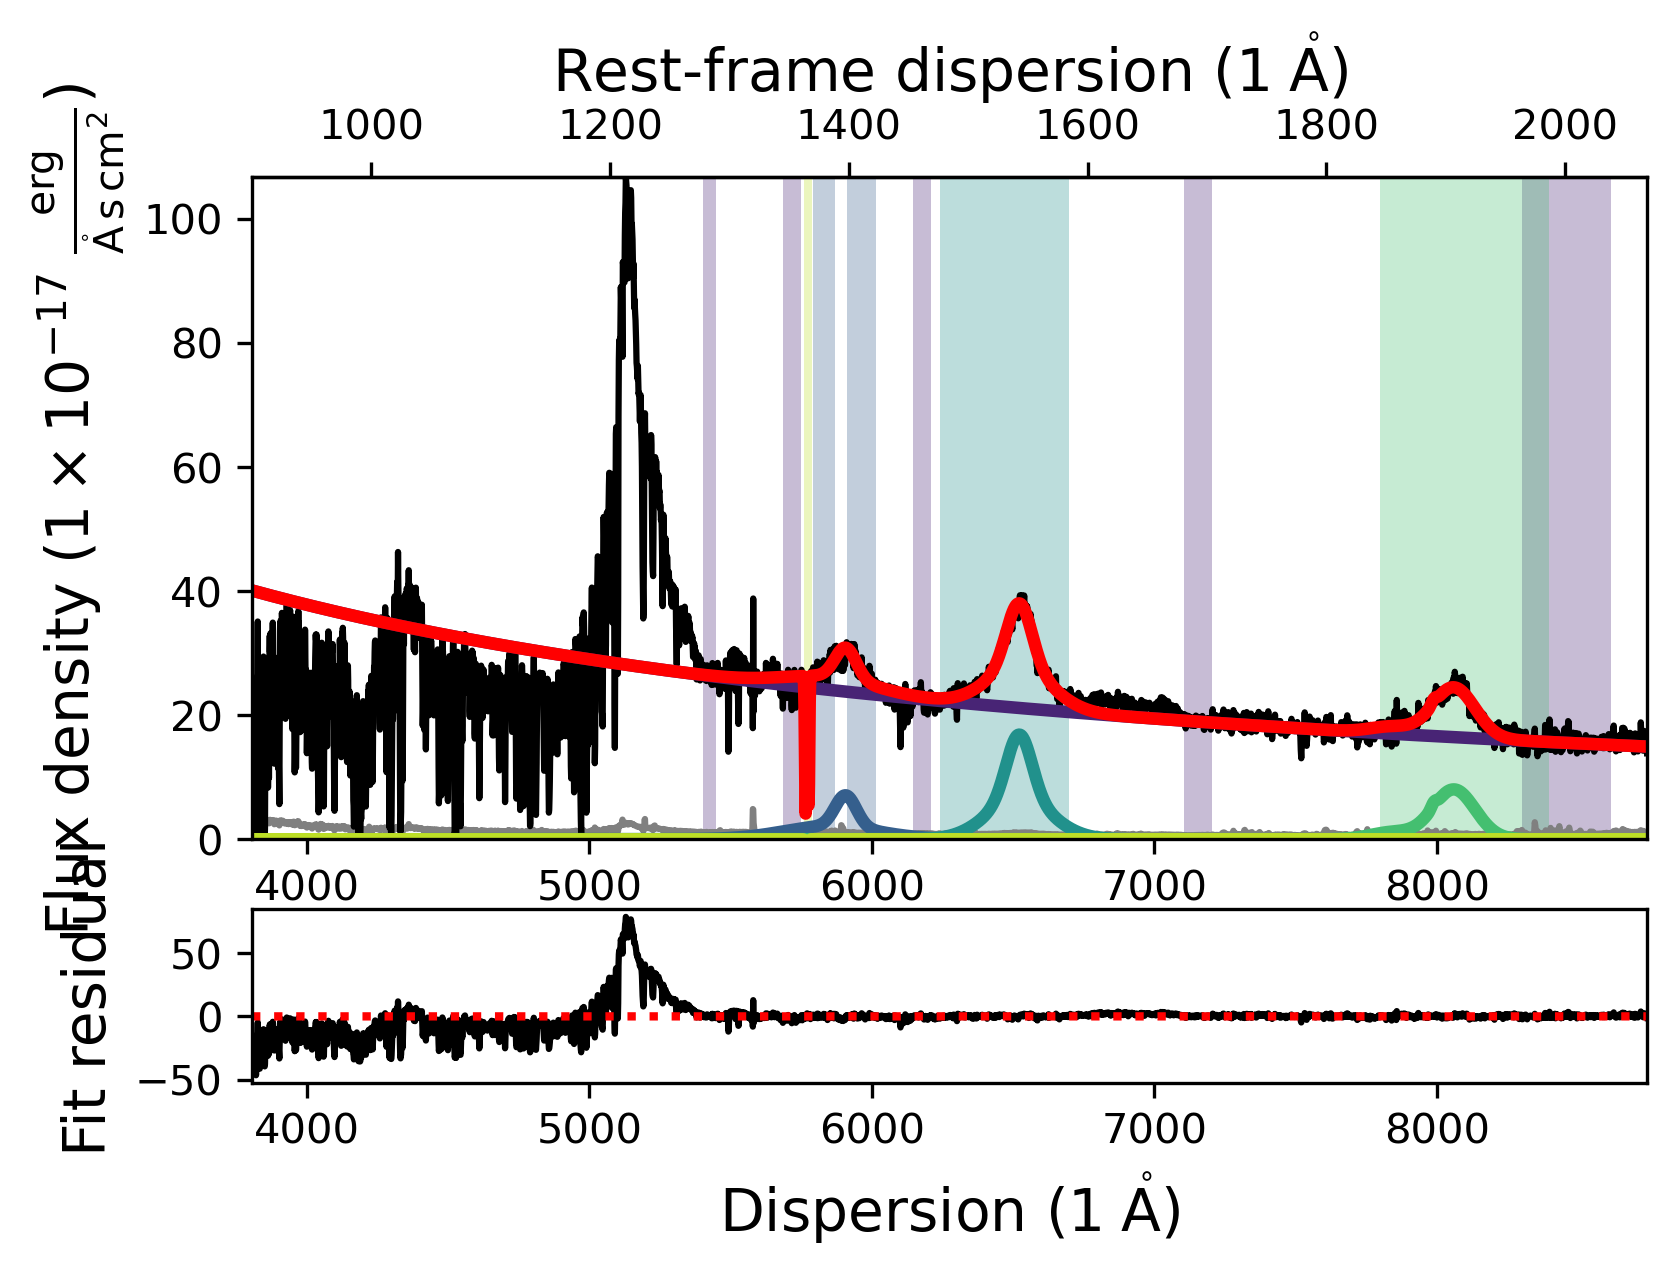

Nelder-Mead


In [31]:
# Instantiate an empty SpecFit object
new_fit = scfit.SpecFit()

# Load the saved model fit using the folder name 
new_fit.load('example_fit_notebook')

# Fit all SpecModels and then display the fit to see if everything worked
new_fit.fit()
new_fit.plot()

# We can also check if it saved the fitting method we changed earlier
print(new_fit.fitting_method)

The full fit you see displayed above should resemble the one a few cells earlier, where we tested changing the fitting method. With this we conclude the demonstration on how to use scripts to construct, fit and save Sculptor model fits.

(We delete the save Sculptor fit to keep the notebook directory clean)

In [32]:
# Delete the Sculptor model fit folder
! rm -r example_fit_notebook
# Check the directory
! ls

TestSpectralBroadening.ipynb scripting_sculptor_3.ipynb
example_spectrum_fit         speconed_demonstration.ipynb
scripting_sculptor_1.ipynb   spectrum_preparation.ipynb
scripting_sculptor_2.ipynb
